## Non-isothermal Recrystillization
The available measurements for recystillization of tungsten come from isothermal experiments. If the operating state of the fusion nuclear reactor equipment is steady, this condition is met perfectly. In the _transient_ case, and more generally speaking, when the temperature $T(t,\mathbf{x}): \{\mathcal{T} \times \mathcal{X} \} \to \mathbb{R}$  where $\mathcal{T}  \subseteq \mathbb{R}_+, \mathcal{X} \subseteq \mathbb{R}^3$ in the component is _not_ independent of time, we will need to extend the isothermal recrystillization model to accomodate this behavior. The notation $T(t,\mathbf{x})$ is replaced by $T(t)$ to simplify the equations, with the connotation being some temperature function at an unspecified point.

### Non-isothermal Recrystillization Assumptions
Let $Y(t)$ be the _Non_-isothermal recrystillization fraction with some aribitrary temperature function T(t). Following [1] we assume that:

1. The _rate_ of recrystillization is equal to the rate of isothermal recrystillization at the same recrystillization fraction $Y(t)$ and temperature $T$.
3. Recrystillization can only proceed forward, i.e. $Y(t)$ must be increasing.

### JMAK model

There are two approaches with a subtle difference. 

#### Case 1
The first, adopting the RXMAT assumptions that the temperature is varying slowly enough that the temperature is constant over a discrete interval allows simplification to a continuous form using standard arguments from calculus: 

$
Y(t)  = \begin{cases}
0 \qquad & t \leq t_0 \\ 
W(t - t_0) \qquad & t > t_0 \\ 
\end{cases} \\
t_0 = \rho^{-1}(1) \qquad \rho = \int \frac{d \tau}{t_{inc}(\tau)} \\ 
W(t) = 1 - \exp{\left\{- \left( \int b(T(\tau)) d\tau \right)^n  \right\}} \\ 
$

#### Case 2
If we do not assume this, we can arrive at the following differential equation for $Z(t)$, where $Y(t) = 1 - \exp{\left(- Z(t) \right)}$

$$
Z^\prime(t) = n Z(t)^{\frac{n-1}{n}}\left[ B(t) + \frac{B^\prime(t)}{B(t)}Z(t)^{\frac{1}{n}}\right] \\ 
B(t) = b(T(t)) \qquad B^\prime(t) = \frac{db}{dT}\frac{dT}{dt}
$$

The explicit solution, and subsitution into the transformation above returns exactly the form of $X$ with $b = b(T(t))$. This is an issue because if $T(t)$ is decreasing fast enough, then $B(T(t))$ may be decreasing fast enough that $Y(t)$ _decreases_, which violates one of our assumptions about the behavior of $Y(t)$. 

In case 1, we used the assumptions to arrive at the following ODE for Z:

$$
Z^\prime(t) = nB(t) Z(t)^{\frac{n-1}{n}}
$$

Which is similar to the first ODE except for the second term in the brackets. $Y(t)$ can only decrease if $B(t) + \frac{B^\prime(t)}{B(t)}Z(t)^{\frac{1}{n}} < 0 $  leading to $Z^\prime(t) < 0$. So we can modify this term (admittadly somewhat empirically) to get the behavior that we want. 

$
Y(t)  = \begin{cases}
0 \qquad & t \leq t_0 \\ 
W(t - t_0) \qquad & t > t_0 \\ 
\end{cases} \\
t_0 = \rho^{-1}(1) \qquad \rho = \int \frac{d \tau}{t_{inc}(\tau)} \\ 
W(t) = 1 - \exp{\left(- Z(t) \right)} \qquad \text{where Z solves} \\ 
Z^\prime(t) = n Z(t)^{\frac{n-1}{n}} \Phi(t,Z) \\
\Phi(t,Z)  = \max(B(t) + \frac{B^\prime(t)}{B(t)}Z(t)^{\frac{1}{n}},0) \\ 
B(t) = b(T(t)) \qquad B^\prime(t) = \frac{db}{dT}\frac{dT}{dt} \\ 
$

[1] A. Durif, M. Richou, G. Kermouche, J. M. Bergheau, "Numerical study of the influence of tungsten recrystallization on the divertor component lifetime" (2021).

TO-DO: GLM.


In [131]:
import numpy as np
from matplotlib import pyplot as plt
from common_util import LogLinearArrhenius,LogLinearArrheniusModelFunc, setup_axis_default
import math
import pickle
from typing import Callable
from scipy.integrate import quad
from scipy.optimize import bisect
from scipy.integrate import solve_ivp

def nonisothermal_jmak_rx_integration_simple(t: np.ndarray,
                                             T: Callable,
                                             jmak_model: LogLinearArrheniusModelFunc):
    

    """"
    numerically integrate the JMAK model with non-isothermal conditions, assuming no 
    temperature rate effects.
    """

    a2 = jmak_model.ap2.params[0]
    A2 = math.exp(jmak_model.ap2.params[0])
    B2 = jmak_model.ap2.params[1]

    a1 = jmak_model.ap1.params[0]
    A1 = math.exp(jmak_model.ap1.params[0])
    B1 = jmak_model.ap1.params[1]
    n = jmak_model.n 

    def b(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def tinc(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def find_start_t():
        
        def rho_func(tt: float):
            return quad(lambda x: 1./tinc(T(x)),0,tt)[0] - 1.   
        
        return bisect(rho_func,t[0],t[-1])
    
    start_t = find_start_t()
    
    def integrate_func(tt: float,_):
        TT = T(tt + start_t)    
        BB = b(TT)
        return BB


    Y = np.zeros_like(t)
    
    index = t > start_t
    Z = solve_ivp(integrate_func,(t[0],t[-1]),np.array([1e-13]),
                         t_eval = (t[index] - start_t),method = 'DOP853',atol = 1e-20)['y'].squeeze()**n  

    Y[index] = 1. - np.exp(-Z)
    return Y

def nonisothermal_jmak_rx_integration(t: np.ndarray,
                                      T: Callable,
                                      Tdiff: Callable,
                                      jmak_model: LogLinearArrheniusModelFunc):
    

    """"
    numerically integrate the JMAK model with non-isothermal conditions,
    allowing for temperature rate effects.
    """

    a2 = jmak_model.ap2.params[0]
    A2 = math.exp(jmak_model.ap2.params[0])
    B2 = jmak_model.ap2.params[1]

    a1 = jmak_model.ap1.params[0]
    A1 = math.exp(jmak_model.ap1.params[0])
    B1 = jmak_model.ap1.params[1]
    n = jmak_model.n 

    def b(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def tinc(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def find_start_t():
        
        def rho_func(tt: float):
            return quad(lambda x: 1./tinc(T(x)),0,tt)[0] - 1.   
        
        return bisect(rho_func,t[0],t[-1])
    
    start_t = find_start_t()

    def integrate_func(tt: float, z: float):

        TT = T(tt + start_t)    
        BB = b(TT)
        dbdT = -A1*B1/(TT**2)*math.exp(B1/TT)
        db = dbdT*Tdiff(tt + start_t)

        return max(n*z**((n-1)/n)*(BB + db/BB*z**(1/n)),0.)
    
    
    Z = np.zeros_like(t)
    index = t > start_t
    Z[~index] = -np.log(1. - 1e-15)

    Z[index] = solve_ivp(integrate_func,(t[0],t[-1]),Z[0:1],
                         t_eval = (t[index] - start_t),
                         method = 'DOP853',atol = 1e-20)['y'].squeeze()  

    return 1. - np.exp(-Z)

def nonisothermal_jmak_rxmat_integration(t: np.ndarray,
                                         T: np.ndarray,
                                         jmak_model: LogLinearArrheniusModelFunc):
    
    """
    integrate the JMAK model with non-isothermal conditions, taking the discrete appraoch
    of the RXMAT model.
    """

    a2 = jmak_model.ap2.params[0]
    A2 = math.exp(jmak_model.ap2.params[0])
    B2 = jmak_model.ap2.params[1]

    a1 = jmak_model.ap1.params[0]
    A1 = math.exp(jmak_model.ap1.params[0])
    B1 = jmak_model.ap1.params[1]
    n = jmak_model.n 

    def b(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def tinc(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def find_start_index() -> int:

        rho = t[0]/tinc(T[0])
        index = 1
        rho_old = 0.0
        while index < t.shape[0] and rho < 1.:
            dt = t[index] - t[index-1]
            rho_old = rho
            rho += dt/tinc(T[index])
            index += 1
        
        m = (rho - rho_old)/dt
        tt = (1. - rho_old)/m
        return index, tt

    index,t_init = find_start_index()
    t_growth = t - t[index] + t_init    
    Y = np.zeros_like(t)

    bb = b(T[index])
    Y[index] = 1. - math.exp(-(bb**n)*t_init**n) 

    for i in range(index+1,len(t_growth)):
        bb = b(T[i])
        t_equiv = 1./bb*np.log(1./(1. - Y[i-1]))**(1./n)
        dt = t_growth[i] - t_growth[i-1]

        Y[i] = 1. - math.exp(-bb**n*(dt + t_equiv)**n)
    
    return Y



# Model Validation
We will focus our attention on validating the numerical model here, to ensure consistency with our assumptions. Validating the ability of this model to match experimental data is beyond the scope of this project. We can ensure at least that our continuous version of the discrete RXMAT model matches their results, and inspect the behavior of the new model that simply ensures increasing recrystillization.

We test the following:
1. Agreement with isothermal case
2. Agreement with discrete jump temperature case
3. Visualization of simple temperature profiles

### 1. Agreement with Isothermal Case
As seen below, both non-isothermal models are consistent with the isothermal model for constant temperature. This is the barest level of agreement we should expect.

e:\ORNL Collaboration\System Design\ASME Code\modeling_tungsten\recrystallization\common_util.py:26: RuntimeWarning: invalid value encountered in power
  1.0 - np.exp(-b**n*(t - t_inc)**n)


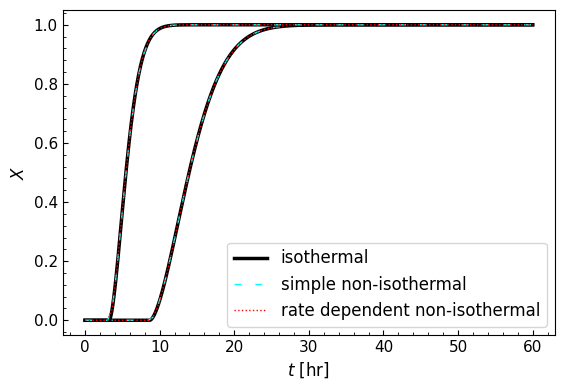

In [167]:
t_eval = np.linspace(0,60*3600,100)
t_func = np.linspace(0.,60*3600,1000)

with open('.model/JMAK_alfonso_data_hr_robust weighted.pkl','rb') as f:
    jmak_model = pickle.load(f)

fig,ax = plt.subplots(figsize = (5.75,4.))
setup_axis_default(ax)
for i,T in enumerate([1200,1250]):
    T_iso = T + 273.15
    Y1 = nonisothermal_jmak_rx_integration_simple(t_eval, lambda x: T_iso, jmak_model)
    Y2 = nonisothermal_jmak_rx_integration(t_eval, lambda x: T_iso, lambda x: 0, jmak_model)
    X = jmak_model.predict(np.array([t_func,T_iso*np.ones_like(t_func)]).T)
    ax.plot(t_func/3600,X,label = 'isothermal' if i == 0 else None,lw = 2.5,color = 'k',ls = '-')
    ax.plot(t_eval/3600,Y1,label = 'simple non-isothermal' if i == 0 else None,lw = 1,color = 'cyan',ls = '--',dashes = (5,10))
    ax.plot(t_eval/3600,Y2,label = 'rate dependent non-isothermal' if i == 0 else None,lw = 1,color = 'red',ls = ':')

ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel('$X$',fontsize = 12)

ax.legend(fontsize = 12)
fig.tight_layout()
fig.savefig('.temp_images/jmak_anisothermal_valid.svg')

### 2. Discrete Jumps

We can use a step temperature function to better visualize the "jumps" in the rate of the recrystillization over time 
Suppose that:

$
T(t) = \begin{cases}
T_1 \qquad & 0 \leq t < t_1 \\ 
T_2 \qquad & t_1 \leq t < t_2 \\
T_3 \qquad & t \geq t_2
\end{cases}
$

Technically, the derivative is undefined at these points, but scipy's numerical integretor doesn't seem to mind this. The below demonstrates what happens when the temperature "switches". For each of these models, it's the same and the rate increases corresponding to the increasing temperature. The lower left plot shows the temperature profile over time, while the rightmost plot shows the isocurves for the chosen fixed temperatures, and the "transitions" between these jump curves.

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_321884\889204611.py:102: RuntimeWarning: invalid value encountered in power
  return max(n*z**((n-1)/n)*(BB + db/BB*z**(1/n)),0.)
e:\ORNL Collaboration\System Design\ASME Code\modeling_tungsten\recrystallization\common_util.py:26: RuntimeWarning: invalid value encountered in power
  1.0 - np.exp(-b**n*(t - t_inc)**n)


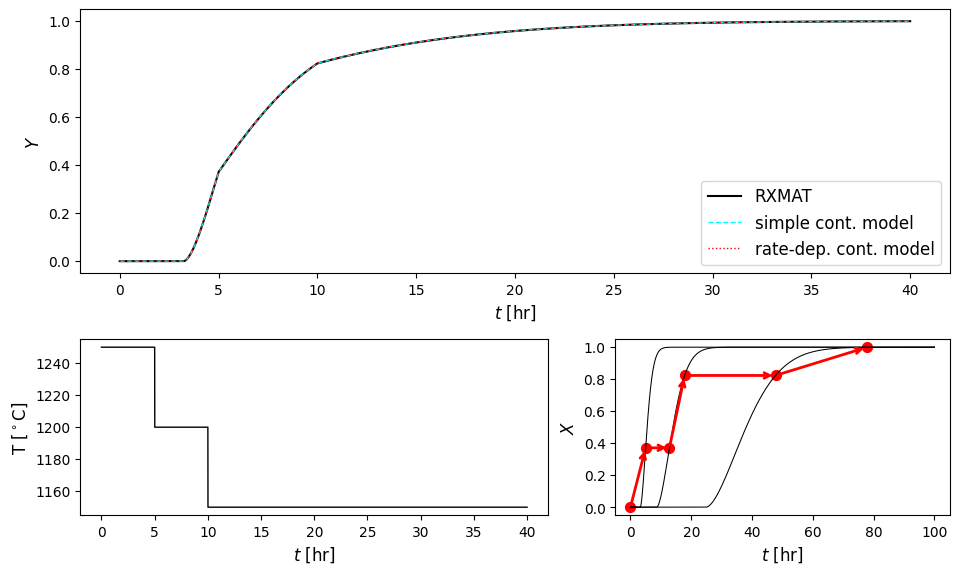

In [176]:
t_1 = 5.0*3600
t_2 = 10.0*3600
t_3 = 40.0*3600
T1 = 1250.0 + 273.15
T2 = 1200.0 + 273.15
T3 = 1150. + 273.15

def jump_temperature(t: float):

    if t < t_1:
        return T1
    elif t > t_1 and t < t_2:
        return T2
    else:
        return T3
    
with open('.model/JMAK_alfonso_data_hr_robust weighted.pkl','rb') as f:
    jmak_model = pickle.load(f)

t_eval = np.linspace(0,t_3,100000)

fig,axes = plt.subplot_mosaic("""
                              AAAAAAA
                              BBBBCCC
                              """,
                              height_ratios= [1.5,1],
                              figsize = (9.25,5.75))

axes = np.array(list(axes.values()))

# plot overall recrystillization profiles
Y_disc = nonisothermal_jmak_rxmat_integration(t_eval,np.array([jump_temperature(t) for t in t_eval]),jmak_model)
axes[0].plot(t_eval/3600,Y_disc,lw = 1.5,color = 'k',ls = '-', label = 'RXMAT')

Y_cont1 = nonisothermal_jmak_rx_integration_simple(t_eval,jump_temperature,jmak_model)
axes[0].plot(t_eval/3600,Y_cont1,lw = 1,color = 'cyan',ls = '--', label = 'simple cont. model')

Y_cont2 = nonisothermal_jmak_rx_integration(t_eval,jump_temperature,lambda x: 0,jmak_model)
axes[0].plot(t_eval/3600,Y_cont2,lw = 1,color = 'red',ls = ':', label = 'rate-dep. cont. model')

#plot the temperature profile
axes[1].plot(t_eval/3600,[jump_temperature(t) - 273.15 for t in t_eval],lw = 1,color = 'k',ls = '-')
axes[1].set_ylabel(r'T [$^\circ$C]',fontsize = 12)
axes[1].set_xlabel(r'$t$ [hr]',fontsize = 12)

t_eval = np.linspace(0,100*3600,100000)
#plot the isothermal models and note the "jump" points between rates
X = jmak_model.predict(np.array([[t_1,T1]])).squeeze()
Xp = jmak_model.predict(np.array([t_eval,np.ones_like(t_eval)*T1]).T)
axes[2].scatter(t_1/3600,X,marker = 'o',color = 'red',s = 50)
axes[2].scatter(0.0,0.0,marker = 'o',color = 'red',s = 50)
axes[2].plot(t_eval/3600,Xp,lw = 0.75,color = 'k',ls = '-')
axes[2].annotate('', xy=(t_1/3600, X), xytext=(0.0,0.0),
                    arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))

a1,b1 = jmak_model.ap1.params
a2,b2 = jmak_model.ap2.params
n = jmak_model.n

t_old = t_1
for dt,TT in zip([t_2 - t_1,t_3 - t_2],[T2,T3]):
    bb = math.exp(a1 + b1/TT)
    tinc = math.exp(a2 + b2/TT)

    t_equiv = 1./bb*np.log(1./(1. - X))**(1./n)
    t_current = dt + t_equiv
    axes[2].scatter((t_equiv + tinc)/3600,X,marker = 'o',color = 'red',s = 50)

    axes[2].annotate('', xy=((t_equiv + tinc)/3600, X), xytext=(t_old/3600, X),
                     arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))
    
    Xnew = 1. - math.exp(-(bb**n)*t_current**n)
    
    axes[2].scatter((t_current + tinc)/3600,Xnew,marker = 'o',color = 'red',s = 50)
    Xp = jmak_model.predict(np.array([t_eval,np.ones_like(t_eval)*TT]).T)
    axes[2].plot(t_eval/3600,Xp,lw = 0.75,color = 'k',ls = '-')
    axes[2].annotate('', xy=((t_current + tinc)/3600, Xnew), xytext=((t_equiv + tinc)/3600, X),
                     arrowprops=dict(arrowstyle='->', color='red',lw = 2.0))
    X = Xnew
    t_old = t_current + tinc

axes[0].set_xlabel(r'$t$ [hr]',fontsize = 12)
axes[0].set_ylabel(r'$Y$',fontsize = 12)
axes[2].set_xlabel(r'$t$ [hr]',fontsize = 12)
axes[2].set_ylabel(r'$X$',fontsize = 12)
axes[0].legend(fontsize = 12)   

fig.subplots_adjust(hspace = 0.3,top = 0.98,right = 0.99,left = 0.05,bottom = 0.1,wspace = 1.0)



### GLM Model

$t^*  = M - \frac{1}{B} \ln{\left(\left( \frac{1}{Y} \right)^\nu - 1 \right)}$

$X^\prime(t) = -\frac{1}{\nu}Z(t)^{-1/\nu - 1}Z^\prime(t)$

$Z(t) = 1 + \exp{-B(t - M)}$ 

$Z^\prime(t) = \left(B \left(M^\prime  -1 \right) + B^\prime (M - t) \right)\exp{-B(t - M)} = u^\dagger(t) ( Z(t) - 1)$

$X^\prime(t) = u(t) Z(t)^{-1/\nu - 1} ( Z(t) - 1)$ 

$u(t) = \frac{-1}{\nu} u^\dagger(t)$


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


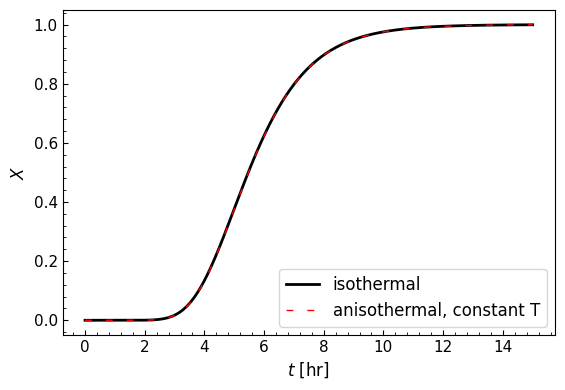

In [18]:

def anisothermal_glm_rx_integration(t: np.ndarray,
                                    T: Callable,
                                    Tdiff: Callable,
                                    glm_model: LogLinearArrheniusModelFunc):
    
    a2 = glm_model.ap2.params[0]
    A2 = math.exp(glm_model.ap2.params[0])
    B2 = glm_model.ap2.params[1]

    a1 = glm_model.ap1.params[0]
    A1 = math.exp(glm_model.ap1.params[0])
    B1 = glm_model.ap1.params[1]
    nu = glm_model.n 


    def B(Temp: float):
        return math.exp(a1 + B1/Temp)
    
    def M(Temp: float):
        return math.exp(a2 + B2/Temp)
    
    def integrate_func(tt: float, y: float,ymin: float):

        BB  = B(T(tt))
        MM = M(T(tt))
        dT = Tdiff(tt)
        TT = T(tt)

        y = max(1e-11,y) # to avoid numerical issues
        y = min(1. - 1e-11,y)

        arg = 1./(y**(-nu) - 1.)
        
        t_star = MM + 1./BB*np.log(arg)
        
        dBdT =  -A1*B1/(TT**2)*math.exp(B1/TT)
        dMdT = -A2*B2/(TT**2)*math.exp(B2/TT)
        dB = dBdT*dT
        dM = dMdT*dT

        delta_t = t_star - MM

        print(dB)
        Zp = (BB*(dM - 1.) + dB*delta_t)*np.exp(-delta_t*BB)
        Z = 1. + np.exp(-delta_t*BB)
        dY_ = -1./nu*Z**(-1./nu-1.)*Zp

        return dY_

    Y=  solve_ivp(integrate_func,(t[0],t[-1]),np.array([1e-20]),t_eval = t,
                       args = (1e-10,),first_step = 1e-15,method = 'DOP853',
                       atol = 1e-20)['y'].squeeze()


    return Y


t_eval = np.linspace(0,15*3600,1000)

with open('.model/Generalized Logistic_alfonso_data_hr_robust weighted.pkl','rb') as f:
    gl_model = pickle.load(f)

T_iso = 1250 + 273.15
Y = anisothermal_glm_rx_integration(t_eval, lambda x: T_iso, lambda x: 0, gl_model)

t_func = np.linspace(0,15*3600,1000)
X = gl_model.predict(np.array([t_func,T_iso*np.ones_like(t_func)]).T)

fig,ax = plt.subplots(figsize = (5.75,4.))
setup_axis_default(ax)

ax.set_xlabel('$t$ [hr]',fontsize = 12)
ax.set_ylabel('$X$',fontsize = 12)
ax.plot(t_func/3600,X,label = 'isothermal',lw = 2,color = 'k',ls = '-')
ax.plot(t_eval/3600,Y,label = 'anisothermal, constant T',lw = 1,color = 'red',ls = '--',dashes = (5,10))

ax.legend(fontsize = 12)
fig.tight_layout()
fig.savefig('.temp_images/glm_anisothermal_valid.svg')




### 3. Temperature Profile Visualizations

To build some intution, we'll compare the RXMAT model, the continuous version of the RXMAT model (case 2), and the new model that simply forces $Y(t)$ to be non-decreasing for three simple cases: 

1. linearly increasing 
2. linearly decreasing
3. An exponential profile

The results are shown below. We can see that the models are quite close for each of the temperature profiles, with the temperature rate dependence in the third model evident by the slightly faster recrystillization for the increasing temperature and the slower recrystillization rate for the decreasing model. 

I'll remark the effect can be pronounced for decreasing temperatures, if the rate of decrease is fast enough then the change in recrystillization is effectively $0$ and the recystilliation can stall.

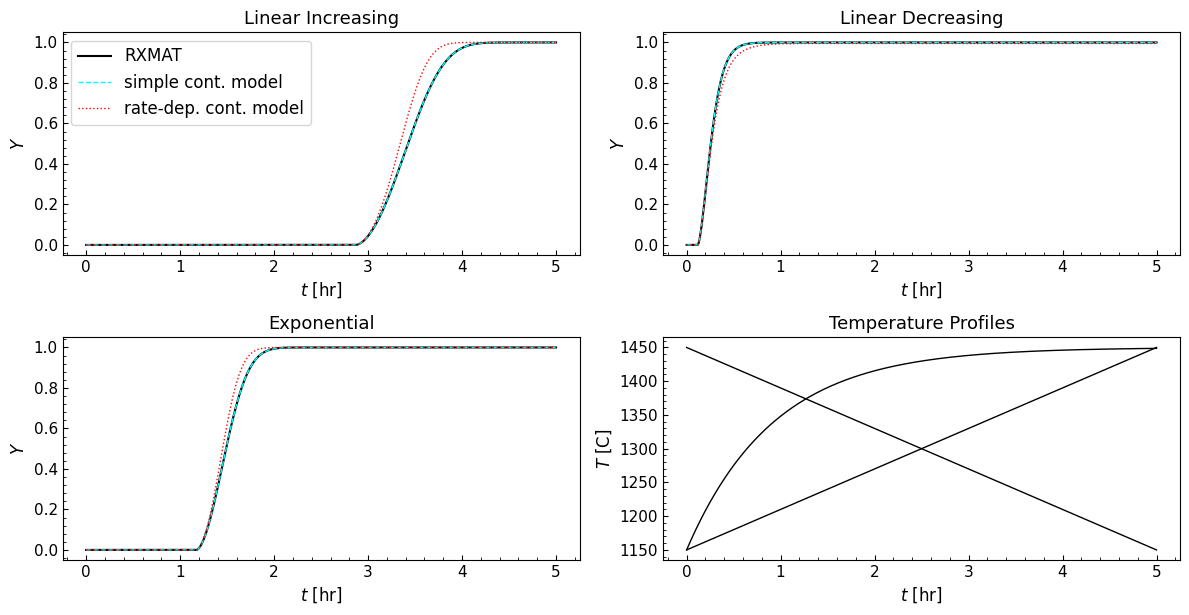

In [166]:
t_eval = np.linspace(0,5*3600,10000)
Tmin = 1150 + 273.15
Tmax = 1450 + 273.15
slope = (Tmax - Tmin)/(t_eval[-1] - t_eval[0])

temperature_funcs = [lambda x: Tmin + slope*x,
                     lambda x: Tmax - slope*x,
                     lambda x: (Tmax - Tmin) * (1- math.exp(-3e-4*x)) + Tmin]

temperature_grads = [lambda x: slope,
                     lambda x: -slope,
                     lambda x: (Tmax - Tmin)*3e-4*math.exp(-3e-4*x)]

titles = ['Linear Increasing','Linear Decreasing','Exponential']
fig,axes = plt.subplots(figsize = (12,6.25),nrows = 2,ncols = 2)
for ax in axes.ravel():
    setup_axis_default(ax)

for tfunc,tgrad,ax,ax_title in zip(temperature_funcs,temperature_grads,axes.ravel(),titles):

    Y_disc = nonisothermal_jmak_rxmat_integration(t_eval,[tfunc(tt) for tt in t_eval],jmak_model)
    ax.plot(t_eval/3600,Y_disc,lw = 1.5,color = 'k',ls = '-', label = 'RXMAT')

    Y_cont1 = nonisothermal_jmak_rx_integration_simple(t_eval,tfunc,jmak_model)
    ax.plot(t_eval/3600,Y_cont1,lw = 1,color = 'cyan',ls = '--', label = 'simple cont. model')

    Y_cont2 = nonisothermal_jmak_rx_integration(t_eval,tfunc,tgrad,jmak_model)
    ax.plot(t_eval/3600,Y_cont2,lw = 1,color = 'red',ls = ':', label = 'rate-dep. cont. model')
    
    ax.set_xlabel('$t$ [hr]',fontsize = 12)
    ax.set_ylabel('$Y$',fontsize = 12)
    ax.set_title(ax_title,fontsize = 13)

axes[0,0].legend(fontsize = 12)

for tfunc in temperature_funcs:
    axes[-1,-1].plot(t_eval/3600,[tfunc(x) - 273.15 for x in t_eval],lw = 1,color = 'k')

axes[-1,-1].set_xlabel('$t$ [hr]',fontsize = 12)    
axes[-1,-1].set_ylabel('$T$ [C]',fontsize = 12)
axes[-1,-1].set_title('Temperature Profiles',fontsize = 13)

fig.tight_layout()
#fig.savefig('.temp_images/anisothermal_visualization.svg')

